In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 6)

from statsmodels.tsa.stattools import adfuller

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR



from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

Original paper: https://s3.amazonaws.com/real.stlouisfed.org/wp/2015/2015-012.pdf
Source: https://research.stlouisfed.org/econ/mccracken/fred-databases/

https://medium.com/@hallmark-nick/deep-learning-in-macroeconomic-forecasting-us-unemployment-cbcc5a33c7c9

Our goal is to forecast:
- Industrial production (INDPRO)
- Headline CPI (CPIAUCSL)
- S&P 500 (S&P 500)

Goals:
- Build predictive (and nowcasting) pipeline for US industrial production, CPI, and stock market 
- Build a similar pipeline for the UK, and Canada 
- Evaluate spillover effects or lead/lag effects in terms of economic activity in trading partners (e.g. Canada and U.S.)

https://www.cambridge.org/core/journals/national-institute-economic-review/article/can-machine-learning-catch-the-covid19-recession/AB27EF7A1A59166C186AC2619110DB4C

http://www.stevanovic.uqam.ca/DS_UKMD.html

http://www.stevanovic.uqam.ca/DS_LCMD.html


To do:
2. Evaluate performance with different lag structure 
3. Conduct factor selection (and factor importance analysis) - which spheres of economy have the strongest signal for industrial production and other target variables
4. Hyperparameter tuning for selected models 
5. 


In [2]:
target_variables = ["INDPRO", "CPIAUCSL", "S&P 500"]

## Data import

In [3]:
#df = pd.read_csv("https://files.stlouisfed.org/files/htdocs/fred-md/monthly/2024-01.csv", header=0)
#df.head()

In [4]:
#df.to_csv("2024_01.csv")

In [93]:
df = pd.read_csv("2024_01.csv")
df.drop(columns = ['Unnamed: 0'], inplace=True)
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9665,23.3891,22.2688,31.7011,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3966,23.7048,22.4617,31.9337,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7193,23.8483,22.5719,31.9337,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.2032,24.1927,22.9026,32.4374,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN


## Transformations

In [6]:
def transform(df=df):

    # transformations codes
    transformations = df.iloc[0,:].copy()
    transformations.name = 'Transformations'
    transformations.drop("sasdate", inplace=True)

    # actual data
    data = df.iloc[1:,:].copy()
    data.index = data["sasdate"]
    del data["sasdate"]

    data.index = pd.to_datetime(data.index)

    # drop columns with many missing values
    drop_list = [
             'ACOGNO', 
             'ANDENOx', 
             'TWEXAFEGSMTHx', 
             'UMCSENTx', 
             'VIXCLSx' # 30 months missing at the beginning of the sample
             ]
    data = data.drop(columns=drop_list)
    transformations = transformations.drop(drop_list)

    # fill missing values 
    data = data.interpolate(method="linear") # only for two series

    def func(x, code):

        if code == 1:
            return x
        elif code == 2:
            return x.diff(1)
        elif code == 3:
            return x.diff(1).diff(1)
        elif code == 4:
            return np.log(x)
        elif code == 5:
            return np.log(x).diff(1)
        elif code == 6:
            return np.log(x).diff(1).diff(1)
        elif code == 7:
            return (x / x.shift(1) - 1).diff(1)
        
    transformed = data.apply(lambda col: func(col, code = transformations[col.name]))

    # exclude the last 6 months and the first 12 months
    transformed = transformed.iloc[12:-6]

    return transformed

In [7]:
data = transform(df)

HOUST 0.055248244571582034
HOUSTNE 0.17420288210464496
HOUSTMW 0.16503485473214075
PERMITNE 0.08914097885628541
PERMITMW 0.10470949579138955


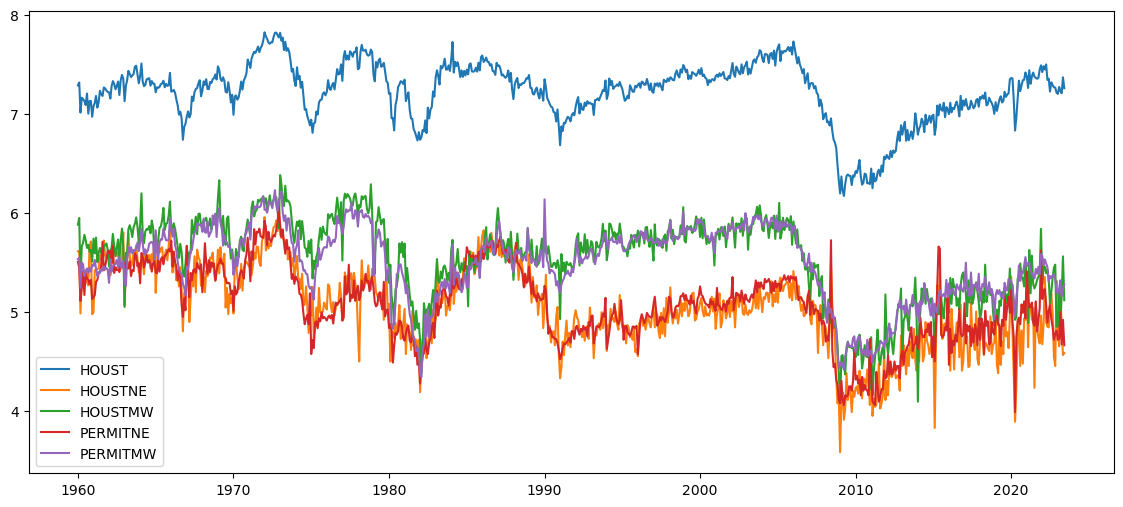

In [8]:
potentially_non_stationary = []

for c in data.columns:
    pvalue = adfuller(data[c])[1] 
    if pvalue > 0.05:
        print(c, pvalue)
        potentially_non_stationary.append(c)


fig, ax = plt.subplots()

for c in potentially_non_stationary:
    ax.plot(data[c], label = c)

ax.legend()
plt.show()

We use the data up to January 1993 for training, and later data for validation. For the purposes of standardisation, we use compute means and stds for the entire sample up to 1993, and after that change them as new observations arrive. # 93 - 23; 93 - 03, 03 - 13, 13 - 23  

In [9]:
def dynamic_normalization(df, cutoff_date = '1993-01-01'):
  
    num_cutoff = df.index.get_loc(cutoff_date)
    df_before = df[:num_cutoff]

    means_before = df_before.mean()
    stds_before = df_before.std()
    
    normalized = (df_before - means_before) / stds_before

    for i in range(num_cutoff, len(df)):
        new_obs = (df[:i] - df[:i].mean()) / df[:i].std()
        last_data_point = pd.DataFrame(new_obs.iloc[-1]).T
        normalized = pd.concat([normalized, last_data_point])

    return normalized
    
    #return normalized_df

In [10]:
data_normalised = dynamic_normalization(df = data)

## PCA

### Variance included in the first X factors.

In [11]:
n_components = 10
pca_core = PCA(n_components = n_components)
principal_components = pd.DataFrame(pca_core.fit_transform(data_normalised), index = data_normalised.index)
print(f'The explained variance ratio is: {pca_core.explained_variance_ratio_.round(3)}')
print(f'Sum of explained variance: {pca_core.explained_variance_ratio_.sum().round(3)}')

The explained variance ratio is: [0.201 0.078 0.063 0.042 0.037 0.035 0.03  0.027 0.025 0.024]
Sum of explained variance: 0.562


### Dynamics of loadings in time

In [12]:
collect_explained_variance = {}

for i in range(100, len(data_normalised)):
    pca = PCA(n_components = n_components)

    data_for_pca = data_normalised[:i+1]

    pca.fit(data_for_pca)
    collect_explained_variance[data_for_pca.index[-1]] = pca.explained_variance_ratio_

explained_variance_df = pd.DataFrame(collect_explained_variance).T
cumsum_explained_variance_df = explained_variance_df.cumsum(axis = 1)

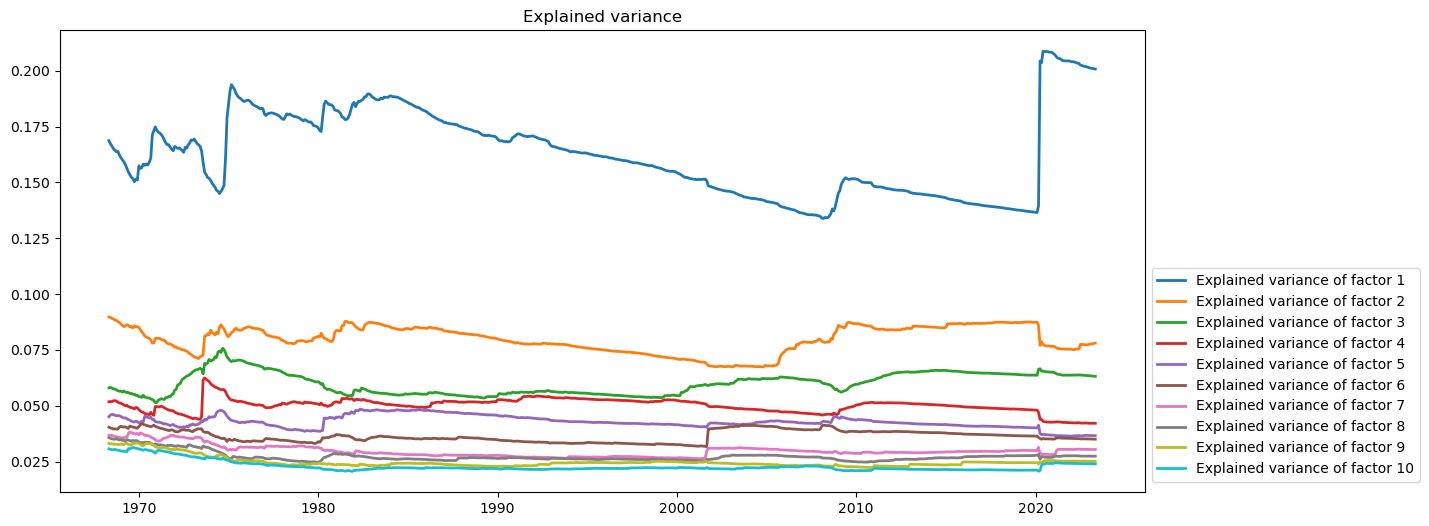

In [13]:
fix, ax = plt.subplots()

plt.title("Explained variance")

for i in range(cumsum_explained_variance_df.shape[1]):
    #ax.plot(cumsum_explained_variance_df.iloc[:, i], label = f"Sum of explained variance up til factor {i+1}", linewidth = 2)
    ax.plot(explained_variance_df.iloc[:, i], label = f"Explained variance of factor {i+1}", linewidth = 2)
    

plt.legend(loc = 'best', bbox_to_anchor=(1, 0.5))
plt.show()

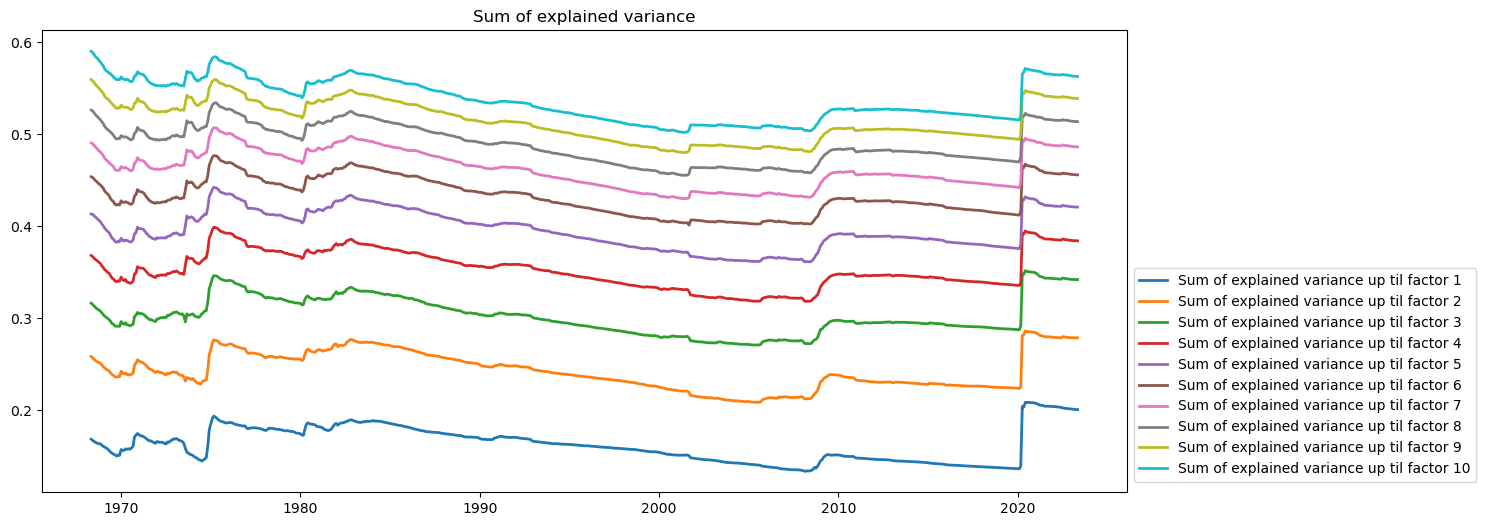

In [14]:
fix, ax = plt.subplots()

plt.title("Sum of explained variance")

for i in range(cumsum_explained_variance_df.shape[1]):
    ax.plot(cumsum_explained_variance_df.iloc[:, i], label = f"Sum of explained variance up til factor {i+1}", linewidth = 2)
    

plt.legend(loc = 'best', bbox_to_anchor=(1, 0.5))
plt.show()

Noticable: 
- Factors are quite stable, except for periods of increased uncertaintly (Covid-19, GFK, 70s);
- Half of the variance is consistently explained by less than 10 factors.

In [15]:
explanatory_power = {}

for i in data_normalised.columns:
    explanatory_power_for_each_input = {}
    for ii in range(principal_components.shape[1]):
        X = principal_components.iloc[:, :(ii + 1)].to_numpy()
        y = data_normalised[i].to_numpy()
        reg = LinearRegression().fit(X, y)
        explanatory_power_for_each_input[ii] = reg.score(X, y)
    
    explanatory_power[i] = explanatory_power_for_each_input 

In [16]:
explanatory_power_df = pd.DataFrame(explanatory_power)
incremental_explanatory_power = explanatory_power_df.copy()

for i in range(explanatory_power_df.shape[0] - 1, 0, -1):
    incremental_explanatory_power.iloc[i, :] = explanatory_power_df.iloc[i, :] - explanatory_power_df.iloc[i-1, :]
explanatory_power_df

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST
0,0.009709,0.246456,0.421205,0.447573,0.352732,0.754022,0.749543,0.683225,0.522492,0.567109,...,0.013347,0.005355,0.005678,0.005707,0.001928,0.000126,0.000042,0.000040,0.000961,0.001677
1,0.067071,0.292930,0.429665,0.447585,0.400127,0.763262,0.751132,0.684406,0.522627,0.567180,...,0.626594,0.035192,0.684571,0.043993,0.002154,0.002081,0.001086,0.000864,0.002346,0.003352
2,0.071249,0.302334,0.477795,0.482281,0.416337,0.794810,0.783348,0.729034,0.582948,0.649897,...,0.675249,0.035199,0.760544,0.044187,0.002718,0.002085,0.001272,0.001165,0.002361,0.003736
3,0.221804,0.347314,0.513376,0.517050,0.438918,0.799068,0.791774,0.736275,0.601011,0.664193,...,0.676106,0.035259,0.761763,0.044211,0.006627,0.002312,0.004697,0.008353,0.012391,0.003774
4,0.389153,0.369953,0.549721,0.523892,0.464523,0.830274,0.805659,0.746680,0.614458,0.668688,...,0.679839,0.046913,0.810225,0.066710,0.006901,0.003327,0.013530,0.014468,0.012443,0.007048
5,0.458014,0.372221,0.555516,0.528716,0.477281,0.845996,0.816306,0.758656,0.634304,0.671882,...,0.702295,0.052921,0.811180,0.098511,0.007455,0.005530,0.013567,0.036359,0.013301,0.020062
6,0.729036,0.468664,0.560162,0.530841,0.488580,0.850304,0.822270,0.765735,0.637664,0.677056,...,0.702498,0.055703,0.816774,0.109268,0.010645,0.005764,0.014568,0.063718,0.049683,0.034125
7,0.763697,0.474834,0.577021,0.535056,0.505682,0.855593,0.836733,0.785968,0.689965,0.715408,...,0.717266,0.055707,0.820215,0.126515,0.013013,0.007193,0.017534,0.079510,0.091489,0.039119
8,0.768780,0.481097,0.584747,0.535769,0.518704,0.875151,0.851401,0.801980,0.727156,0.727448,...,0.721526,0.056702,0.841160,0.132207,0.016393,0.016324,0.017805,0.081281,0.104575,0.059019
9,0.779407,0.481122,0.590001,0.539283,0.518779,0.914645,0.902890,0.872091,0.784738,0.741449,...,0.722785,0.056932,0.844249,0.151333,0.019009,0.019038,0.023797,0.092502,0.112088,0.075965


In [17]:
incremental_explanatory_power.mean(axis = 1)

0    0.183770
1    0.072833
2    0.064301
3    0.048305
4    0.040943
5    0.028382
6    0.033860
7    0.025848
8    0.026053
9    0.021443
dtype: float64

In [18]:
incremental_explanatory_power.index = [f"PC {i+1}" for i in range(n_components)]
incremental_explanatory_power.T.sort_values("PC 1", ascending=False)["PC 1"][:10]

PAYEMS       0.853176
IPMANSICS    0.796411
USGOOD       0.785996
INDPRO       0.754022
IPFPNSS      0.749543
MANEMP       0.740278
CUMFNS       0.736141
SRVPRD       0.713983
USTPU        0.702227
DMANEMP      0.692374
Name: PC 1, dtype: float64

In [19]:
incremental_explanatory_power.T.sort_values("PC 2", ascending=False)["PC 2"][:10]

CUSR0000SAC        0.714165
CUSR0000SA0L2      0.698745
DNDGRG3M086SBEA    0.678893
CPIAUCSL           0.674383
CUSR0000SA0L5      0.647175
PCEPI              0.613246
CPITRNSL           0.596821
CPIULFSL           0.562945
WPSFD49502         0.529144
WPSFD49207         0.506897
Name: PC 2, dtype: float64

In [20]:
incremental_explanatory_power.T.sort_values("PC 3", ascending=False)["PC 3"][:10]

HOUST       0.644036
PERMIT      0.613019
PERMITW     0.570538
HOUSTW      0.565754
HOUSTS      0.538933
PERMITMW    0.476196
HOUSTMW     0.435060
PERMITNE    0.398632
PERMITS     0.393038
HOUSTNE     0.335831
Name: PC 3, dtype: float64

In [21]:
incremental_explanatory_power.T.sort_values("PC 4", ascending=False)["PC 4"][:10]

S&P div yield    0.325393
S&P PE ratio     0.293772
S&P 500          0.273026
S&P: indust      0.267269
BAA              0.241791
T5YFFM           0.229129
AAAFFM           0.224854
T10YFFM          0.221278
BAAFFM           0.219109
M2REAL           0.189596
Name: PC 4, dtype: float64

In [22]:
incremental_explanatory_power.T.sort_values("PC 5", ascending=False)["PC 5"][:10]

GS1         0.199258
CP3Mx       0.178316
TB6MS       0.178065
GS5         0.172605
RPI         0.167349
AAA         0.165070
TB6SMFFM    0.164765
BAA         0.162173
TB3SMFFM    0.160461
T1YFFM      0.155590
Name: PC 5, dtype: float64

In [23]:
incremental_explanatory_power.T.sort_values("PC 6", ascending=False)["PC 6"][:10]

M1SL         0.393763
M2SL         0.263777
TOTRESNS     0.217347
NONBORRES    0.151632
TB6MS        0.145056
TB3MS        0.143809
GS1          0.142841
GS5          0.141055
GS10         0.120603
CONSPI       0.098709
Name: PC 6, dtype: float64

The results are similar to what has been shown in https://s3.amazonaws.com/real.stlouisfed.org/wp/2015/2015-012.pdf both in terms of groups identified based on factor loadings approximated using incremental change in the coefficient of determination as more factors are added and in terms of the average loadings of factors. Important to note that this approach ignores lead-lag structure within the data corresponding to the same area of economic activity, i.e. leading, coincident and lagging indicators are most probably explained by different factors in such decomposition. To overcome such limitation we might be more interested in using only leading and/or coincident indicators and extract principal components from them in order to have a better overview of underlying forces within leading economic signals.

## Baseline models

Data: 
- All variables except for the target
- Factors (iteratively re-estimated)
- Lags (1, 3, 6, 12)

Forecast:
- 1M, 3M, 6M, 12M

In [128]:
def prepare_before_train_test(df, target, h_ahead, lags, cutoff_date):

    y_raw = df[target].copy()
    X_raw = df.loc[:, df.columns != target].copy()

    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X_raw)
    X_normalized_df = pd.DataFrame(X_normalized, index = X_raw.index, columns=X_raw.columns)

    for c in X_normalized_df.columns:
        for l in lags:
            name = f"{c}, {l}-month lag"
            new = X_normalized_df[c].shift(l)
            new.name = name
            
            X_normalized_df = pd.concat([X_normalized_df, new], axis=1)

    y_shifted = y_raw.shift(-h_ahead)

    if len(lags) > 0:
        y = y_shifted.iloc[max(lags):-h_ahead]
        X = X_normalized_df.iloc[max(lags):-h_ahead]
    else:
        y = y_shifted.iloc[:-h_ahead]
        X = X_normalized_df.iloc[:-h_ahead]

    assert y.index.get_loc(cutoff_date) == X.index.get_loc(cutoff_date)
    num_cutoff = y.index.get_loc(cutoff_date)
    
    y_train = y.iloc[:num_cutoff]
    X_train = X.iloc[:num_cutoff]

    y_test = y.iloc[num_cutoff:]
    X_test = X.iloc[num_cutoff:]
    
    return y_train, X_train, y_test, X_test


def collect_stats(y_test, y_pred):
    
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return (mse, mape, mae)

### Industrial production modelling

In [169]:
target = "INDPRO"
h_ahead = 3
lags = [1, 2]
cutoff_date = '1993-01-01'

#yX_groups = {t: prepare_before_train_test(data, target=t, h_ahead=h_ahead, lags=lags) for t in target_variables}

y_train, X_train, y_test, X_test = prepare_before_train_test(data, target=target, h_ahead=h_ahead, lags=lags, cutoff_date=cutoff_date)

### Pipeline for modelling 

- Run models on the full dataset (without feature extraction - PCA; and afterwards use extracted features)
- Apply hyperparameter tuning for all models - see how do they behave 
- See which features / factors from PCA are the most meaningful 
- See whether there are correlations between principal components for the three countries 
- 

To do:
- add: from sklearn.linear_model import lars_path _, _, coefs = lars_path(X_train, y_train, method="lasso", verbose=True)
- Run hyperparameter testing for each model 


In [ ]:
models = [Ridge,
        Lasso, 
        ElasticNet, 
        MLPRegressor, 
        RandomForestRegressor, 
        SVR, ]

In [171]:
y_pred_rw = data[target].iloc[data.index.get_loc(cutoff_date):-h_ahead]
rw = collect_stats(y_test=y_test, y_pred=y_pred_rw)

rw

(0.0002550195673782672, 10.151361155363261, 0.007186056001090448)

In [183]:
ridge = Ridge(alpha = 2)

ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

ridge_results = collect_stats(y_test=y_test, y_pred=y_pred_ridge)
ridge_results

(0.00027657085411165994, 33.758061082651835, 0.010606298824070798)

In [184]:
lasso = Lasso(alpha = 1)

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_results = collect_stats(y_test=y_test, y_pred=y_pred_lasso)
lasso_results

(0.00012367062719136998, 5.926717506040086, 0.005465947323488429)

In [186]:
svr = SVR()

svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

svr_results = collect_stats(y_test=y_test, y_pred=y_pred_svr)
svr_results

(0.00014084437390045204, 7.314365417262724, 0.007075049260725212)

In [ ]:
svr = ElasticNet()

svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

svr_results = collect_stats(y_test=y_test, y_pred=y_pred_svr)
svr_results

### Inflation modelling 

In [187]:
target = "CPIAUCSL"
h_ahead = 3
lags = [1, 2]
cutoff_date = '1993-01-01'

#yX_groups = {t: prepare_before_train_test(data, target=t, h_ahead=h_ahead, lags=lags) for t in target_variables}

y_train, X_train, y_test, X_test = prepare_before_train_test(data, target=target, h_ahead=h_ahead, lags=lags, cutoff_date=cutoff_date)

In [189]:
y_pred_rw = data[target].iloc[data.index.get_loc(cutoff_date):-h_ahead]
rw = collect_stats(y_test=y_test, y_pred=y_pred_rw)

rw

(1.7839895129816417e-05, 7684479433.887742, 0.0029397968704684657)

In [188]:
ridge = Ridge(alpha = 2)

ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

ridge_results = collect_stats(y_test=y_test, y_pred=y_pred_ridge)
ridge_results

(2.9406996109215887e-05, 30409653567.489006, 0.0038788184867017276)

In [190]:
lasso = Lasso(alpha = 1)

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_results = collect_stats(y_test=y_test, y_pred=y_pred_lasso)
lasso_results

(8.335606711992783e-06, 12015882.390275467, 0.0020257363056077364)

In [191]:
svr = SVR()

svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

svr_results = collect_stats(y_test=y_test, y_pred=y_pred_svr)
svr_results

(1.3247069883643797e-05, 27509159433.512016, 0.002826354565581217)

### S&P 500 modelling

In [192]:
target = "S&P 500"
h_ahead = 3
lags = [1, 2]
cutoff_date = '1993-01-01'

#yX_groups = {t: prepare_before_train_test(data, target=t, h_ahead=h_ahead, lags=lags) for t in target_variables}

y_train, X_train, y_test, X_test = prepare_before_train_test(data, target=target, h_ahead=h_ahead, lags=lags, cutoff_date=cutoff_date)

### Alternative datasets

In [196]:
df_canada = pd.read_csv("LCDMA_January_2024/TR_CAN_MD.csv")
#df_canada.drop(columns = ['Unnamed: 0'], inplace=True)
df_canada.index = df_canada["Date"]
del df_canada["Date"]
df_canada.head()

,GDP_new,BSI_new,GPI_new,SPI_new,IP_new,NDM_new,DM_new,OILP_new,CON_new,RT_new,...,CPI_MINUS_FOO_BC,CPI_MINUS_FEN_BC,CPI_GOO_BC,CPI_DUR_BC,CPI_SERV_BC,CRED_T_discontinued,CRED_HOUS_discontinued,CRED_MORT_discontinued,CRED_CONS_discontinued,CRE_BUS_discontinued
Date,,,,,,,,,,,,,,,,,,,,,
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
df_canada_short = df_canada.iloc[df_canada.index.get_loc("1960-01-01"):]
df_canada_short.isna().sum(axis = 1)[180:190]

Date
1975-01-01    332
1975-02-01    332
1975-03-01    332
1975-04-01    332
1975-05-01    332
1975-06-01    332
1975-07-01    332
1975-08-01    332
1975-09-01    332
1975-10-01    332
dtype: int64

In [206]:
df_uk = pd.read_csv("UKMD_January_2024/tr_uk_md.csv")
#df_canada.drop(columns = ['Unnamed: 0'], inplace=True)
df_uk.index = df_uk["Date"]
del df_uk["Date"]
df_uk.head()

,Unnamed: 0,EMP,EMP_PART,EMP_TEMP,UNEMP_RATE,UNEMP_DURA_6mth,UNEMP_DURA_6.12mth,UNEMP_DURA_12mth.,UNEMP_DURA_24mth.,EMP_RATE,...,UK_focused_equity,EUR_UNC_INDEX,BCI,CCI,CLI,PPI_MANU,PPI_MACH,PPI_OIL,PPI_METAL,PPI_MOTOR
Date,,,,,,,,,,,,,,,,,,,,,
1948-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-02-01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-03-01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-04-01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-05-01,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
